# Scale-Free Networks

Code examples from [Think Complexity, 2nd edition](http://greenteapress.com/wp/complexity2), Chapter 4

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [1]:
from __future__ import print_function, division

%matplotlib inline
%precision 3

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

import random
import networkx as nx
import numpy as np

import thinkplot

# colors from our friends at http://colorbrewer2.org
COLORS = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462',
          '#b3de69','#fccde5','#d9d9d9','#bc80bd','#ccebc5','#ffed6f']

In [2]:
from thinkstats2 import RandomSeed
RandomSeed(17)

## Facebook data

The following function reads a file with one edge per line, specified by two integer node IDs.

In [3]:
def read_graph(filename):
    G = nx.Graph()
    array = np.loadtxt(filename, dtype=int)
    G.add_edges_from(array)
    return G

We'll read the Facecook data downloaded from [SNAP](https://snap.stanford.edu/data/egonets-Facebook.html)

In [4]:
# https://snap.stanford.edu/data/facebook_combined.txt.gz

fb = read_graph('facebook_combined.txt.gz')
n = len(fb)
m = len(fb.edges())
n, m

(4039, 88234)

With larger graphs, it takes too long to compute clustering coefficients and path lengths, but we can estimate them by sampling.  NetworkX provides a function in its approximation module that estimates the clustering coefficient:

In [5]:
from networkx.algorithms.approximation import average_clustering

And I've written a function that estimates the average path length.

In [6]:
def random_path_lengths(G, nodes=None, trials=1000):
    """Choose random pairs of nodes and compute the path length between them.

    G: Graph
    nodes: list of nodes to choose from
    trials: number of pairs to choose

    returns: list of path lengths
    """
    if nodes is None:
        nodes = G.nodes()
    else:
        nodes = list(nodes)
        
    pairs = np.random.choice(nodes, (trials, 2))
    lengths = [nx.shortest_path_length(G, *pair) 
               for pair in pairs]
    return lengths

def estimate_path_length(G, nodes=None, trials=1000):
    return np.mean(random_path_lengths(G, nodes, trials))

The average clustering coefficient is high.

In [7]:
C = average_clustering(fb)
C

0.603

The average path length is low.

In [8]:
L = estimate_path_length(fb)
L

3.686

## WS Graph

Next I'll construct a WS graph with the same number of nodes and average degree as the Facebook network:

In [9]:
n = len(fb)
m = len(fb.edges())
k = int(round(2*m/n))
k

44

With `p=0` we get a ring lattice.

The number of edges is a little bigger than in the dataset because we have to round `k` to an integer.

In [10]:
lattice = nx.watts_strogatz_graph(n, k, p=0)
len(lattice), len(lattice.edges())

(4039, 88858)

The clustering coefficient is a little higher than in the dataset.

In [11]:
C, average_clustering(lattice)

(0.603, 0.728)

And the path length is much higher.

In [12]:
L, estimate_path_length(lattice)

(3.686, 47.088)

With `p=1` we get a random graph.

In [13]:
random_graph = nx.watts_strogatz_graph(n, k, p=1)

The clustering coefficient is small.

In [14]:
C, average_clustering(random_graph)

(0.603, 0.017)

And the path lengths are very small.

In [15]:
L, estimate_path_length(random_graph)

(3.686, 2.597)

By trial and error, I found that `p=0.05` yields a graph with about the right values for `C` and `L`.

In [16]:
ws = nx.watts_strogatz_graph(n, k, 0.05, seed=15)

The clustering coefficient is a little higher than in the data.

In [17]:
C, average_clustering(ws)

(0.603, 0.630)

And the path length is a little lower.

In [18]:
L, estimate_path_length(ws)

(3.686, 3.264)

So that seems good so far.

## Degree

But let's look at the degree distribution.

The following function returns a list of degrees, one for each node:

In [19]:
def degrees(G):
    """List of degrees for nodes in `G`.
    
    G: Graph object
    
    returns: list of int
    """
    return [G.degree(u) for u in G]

The average degree in the WS model is about right.

In [20]:
np.mean(degrees(fb)), np.mean(degrees(ws))

(43.691, 44.000)

But the standard deviation isn't even close:

In [21]:
np.std(degrees(fb)), np.std(degrees(ws))

(52.414, 1.431)

To see what's going on, we need to look at the whole distribution.

I'll start with a very small graph:

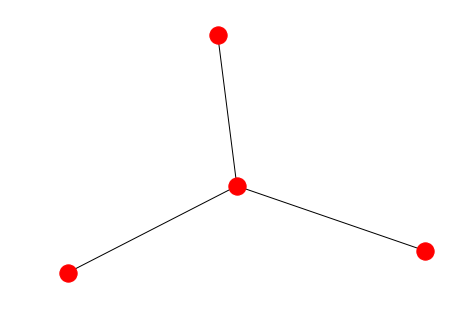

In [22]:
G = nx.Graph()
G.add_edge(1, 0)
G.add_edge(2, 0)
G.add_edge(3, 0)
nx.draw(G)

Here's what the list of degrees looks like for this graph:

In [23]:
degrees(G)

[3, 1, 1, 1]

To compute the degree distribution, I'll use the `Pmf` class from `thinkstats2`

In [24]:
from thinkstats2 import Pmf

A `Pmf` object maps from each degree to the fraction of nodes with that degree.

In [25]:
Pmf(degrees(G))

Pmf({1: 0.75, 3: 0.25})

75% of the nodes have degree 1; 25% have degree 3.

We can visualize the distribution as a histogram:

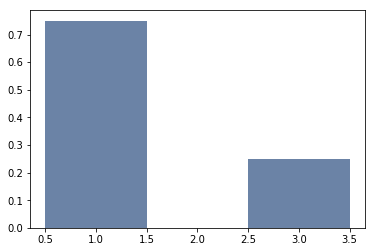

In [26]:
thinkplot.Hist(Pmf(degrees(G)), width=1)

And we can use the `Pmf` to compute mean and standard deviation:

In [27]:
pmf_fb = Pmf(degrees(fb))
pmf_fb.Mean(), pmf_fb.Std()

(43.691, 52.414)

In [28]:
pmf_ws = Pmf(degrees(ws))
pmf_ws.Mean(), pmf_ws.Std()

(44.000, 1.431)

We can also use the `Pmf` to look up the fraction of nodes with exactly 1 neighbor.

In [29]:
pmf_fb[1], pmf_ws[1]

(0.019, 0)

Here's what the degree distributions look like for the Facebook data and the WS model.  They don't resemble each other at all.

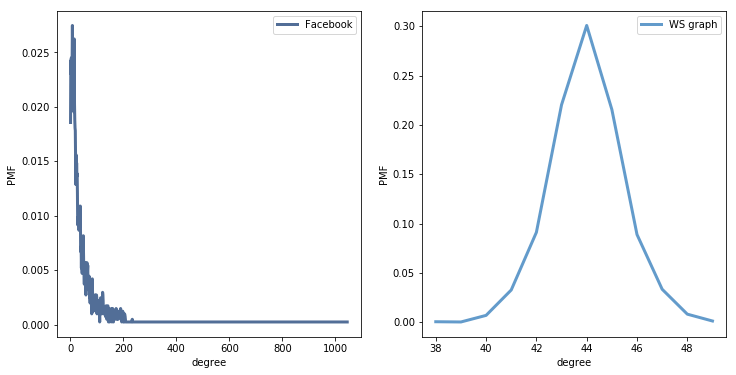

In [30]:
thinkplot.preplot(cols=2)

thinkplot.Pdf(pmf_fb, label='Facebook')
thinkplot.config(xlabel='degree', ylabel='PMF')

thinkplot.subplot(2)

thinkplot.Pdf(pmf_ws, label='WS graph')
thinkplot.config(xlabel='degree', ylabel='PMF')

plt.savefig('chap04-1.pdf')

We can get a better view of the Facebook data by plotting the PMF on a log-log scale.

The result suggests that the degree distribution follows a power law, at least for values larger than 10 or so.

The log-log scale doesn't help the WS graph.

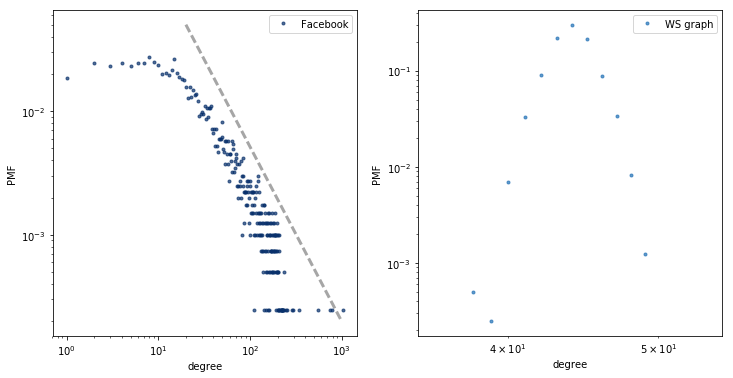

In [31]:
thinkplot.preplot(cols=2)

thinkplot.plot([20, 1000], [5e-2, 2e-4], color='gray', linestyle='dashed')

thinkplot.Pdf(pmf_fb, style='.', label='Facebook')
thinkplot.config(xscale='log', yscale='log',
                 xlabel='degree', ylabel='PMF')

thinkplot.subplot(2)

thinkplot.Pdf(pmf_ws, style='.', label='WS graph')
thinkplot.config(xlim=[35, 55], 
                 xscale='log', yscale='log',
                 xlabel='degree', ylabel='PMF')

plt.savefig('chap04-2.pdf')

The discrepancy between the actual degree distribution and the WS model is the motivation for the BA model.

## BA model

Here's a simplified version of the NetworkX function that generates BA graphs.

In [32]:
# modified version of the NetworkX implementation from
# https://github.com/networkx/networkx/blob/master/networkx/generators/random_graphs.py

def barabasi_albert_graph(n, k, seed=None):
    """Constructs a BA graph.
    
    n: number of nodes
    k: number of edges for each new node
    seed: random seen
    """
    if seed is not None:
        random.seed(seed)
    
    G = nx.empty_graph(k)
    targets = list(range(k))
    repeated_nodes = []

    for source in range(k, n):

        G.add_edges_from(zip([source]*k, targets))

        repeated_nodes.extend(targets)
        repeated_nodes.extend([source] * k)

        targets = _random_subset(repeated_nodes, k)

    return G

And here's the function that generates a random subset without repetition.

In [33]:
def _random_subset(repeated_nodes, k):
    """Select a random subset of nodes without repeating.
    
    repeated_nodes: list of nodes
    k: size of set
    
    returns: set of nodes
    """
    targets = set()
    while len(targets) < k:
        x = random.choice(repeated_nodes)
        targets.add(x)
    return targets

I'll generate a BA graph with the same number of nodes and edges as the Facebook data:

In [34]:
n = len(fb)
m = len(fb.edges())
k = int(round(m/n))
n, m, k

(4039, 88234, 22)

Providing a random seed means we'll get the same graph every time.

In [35]:
ba = barabasi_albert_graph(n, k, seed=15)

The number of edges is pretty close to what we asked for.

In [36]:
len(ba), len(ba.edges()), len(ba.edges())/len(ba)

(4039, 88374, 21.880)

So the mean degree is about right.

In [37]:
np.mean(degrees(fb)), np.mean(degrees(ba))

(43.691, 43.760)

The standard deviation of degree is pretty close, and much better than the WS model.

In [38]:
np.std(degrees(fb)), np.std(degrees(ba))

(52.414, 41.029)

Let's take a look at the degree distribution.

In [39]:
pmf_ba = Pmf(degrees(ba))

Looking at the PMFs on a linear scale, we see one difference, which is that the BA model has no nodes with degree less than `k`, which is 22.

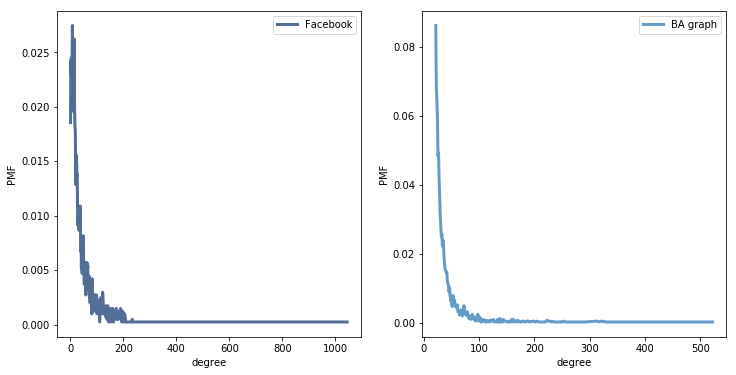

In [40]:
thinkplot.preplot(cols=2)

thinkplot.Pdf(pmf_fb, label='Facebook')
thinkplot.config(xlabel='degree', ylabel='PMF')

thinkplot.subplot(2)

thinkplot.Pdf(pmf_ba, label='BA graph')
thinkplot.config(xlabel='degree', ylabel='PMF')

But if we look at the PMF on a log-log scale, the BA model looks pretty good for values bigger than about 20.  And it seems to follow a power law.

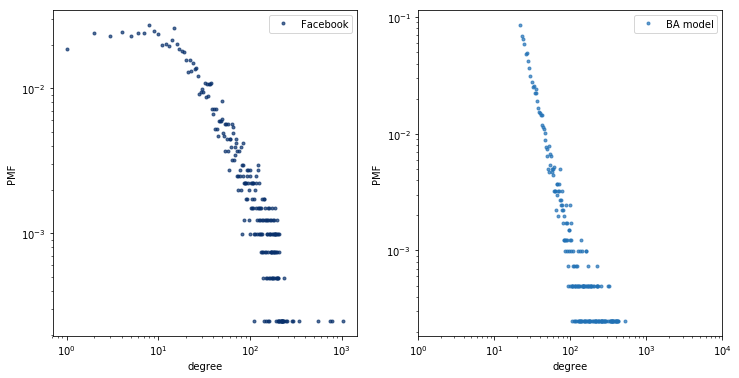

In [41]:
thinkplot.preplot(cols=2)

thinkplot.Pdf(pmf_fb, style='.', label='Facebook')
thinkplot.config(xlabel='degree', ylabel='PMF')
thinkplot.config(xscale='log', yscale='log')

thinkplot.subplot(2)

thinkplot.Pdf(pmf_ba, style='.', label='BA model')
thinkplot.config(xlabel='degree', ylabel='PMF')
thinkplot.config(xlim=[1, 1e4],
                 xscale='log', yscale='log')

plt.savefig('chap04-3.pdf')

The characteristic path length is even smaller in the model than in the data.

In [42]:
L, estimate_path_length(ba)

(3.686, 2.519)

But the clustering coefficient isn't even close.

In [43]:
C, average_clustering(ba)

(0.603, 0.033)

In the BA model, the degree distribution is better than in the WS model, but the clustering coefficient is too low.

## Cumulative distributions

Cumulative distributions are a better way to visualize distributions.  The following function shows what a cumulative probability is:

In [44]:
def cumulative_prob(pmf, x):
    """Computes the cumulative probability of `x`.
    
    Total probability of all values <= x.
    
    returns: float probability
    """
    ps = [pmf[value] for value in pmf if value<=x]
    return sum(ps)

The total probability for all values up to and including 11 is 0.258, so the 25th percentile is about 11.

In [45]:
cumulative_prob(pmf_fb, 11)

0.258

The median degree is about 25.

In [46]:
cumulative_prob(pmf_fb, 25)

0.506

And the 75th percentile is about 57.  That is, about 75% of users have 57 friends or fewer.

In [47]:
cumulative_prob(pmf_fb, 57)

0.752

`thinkstats2` provides `Cdf`, which computes cumulative distribution functions.

In [48]:
from thinkstats2 import Cdf

Here are the degree CDFs for the Facebook data, the WS model, and the BA model.

In [49]:
cdf_fb = Cdf(degrees(fb), label='Facebook')

In [50]:
cdf_ws = Cdf(degrees(ws), label='WS model')

In [51]:
cdf_ba = Cdf(degrees(ba), label='BA model')

If we plot them on a log-x scale, we get a sense of how well the models fit the central part of the distribution.

The WS model is hopeless.  The BA model is ok for values above the median, but not very good for smaller values.

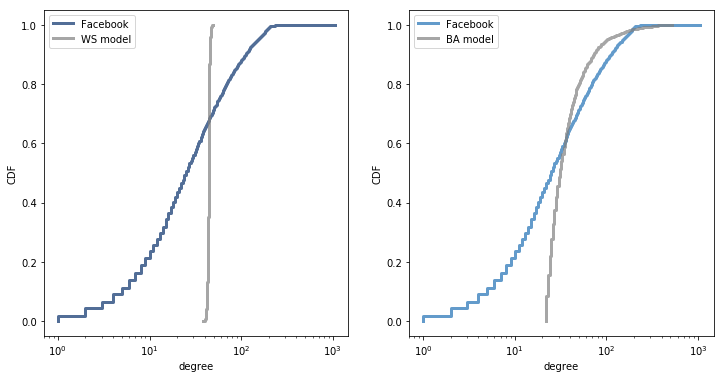

In [53]:
thinkplot.preplot(cols=2)

thinkplot.Cdf(cdf_fb)
thinkplot.Cdf(cdf_ws, color='gray')
thinkplot.config(xlabel='degree', xscale='log',
                 ylabel='CDF')

thinkplot.subplot(2)

thinkplot.Cdf(cdf_fb, label='Facebook')
thinkplot.Cdf(cdf_ba, color='gray')
thinkplot.config(xlabel='degree', xscale='log',
                 ylabel='CDF')
plt.savefig('chap04-4.pdf')

On a log-log scale, we see that the BA model fits the tail of the distribution reasonably well.

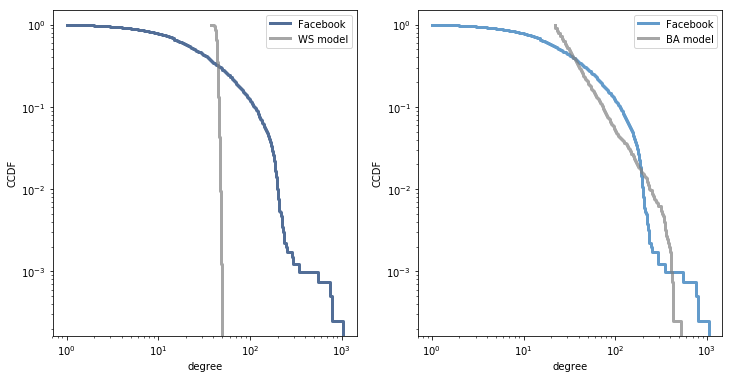

In [54]:
thinkplot.preplot(cols=2)

thinkplot.Cdf(cdf_fb, complement=True)
thinkplot.Cdf(cdf_ws, color='gray', complement=True)
thinkplot.config(xlabel='degree', xscale='log',
                 ylabel='CCDF', yscale='log')

thinkplot.subplot(2)

thinkplot.Cdf(cdf_fb, label='Facebook', complement=True)
thinkplot.Cdf(cdf_ba, color='gray', complement=True)
thinkplot.config(xlabel='degree', xscale='log',
                 ylabel='CCDF', yscale='log')

plt.savefig('chap04-5.pdf')

But there is certainly room for a model that does a better job of fitting the whole distribution.

## Exercises

**Exercise:** Data files from the Barabasi and Albert paper are available from
[this web page](http://www3.nd.edu/~networks/resources.htm).

Their actor collaboration data is included in the repository for this book in a file named
`actor.dat.gz`.  The following function reads the file and builds the graph.

In [55]:
import gzip

def read_actor_network(filename, n=None):
    """Reads graph data from a file.
    
    filename: string
    n: int, number of lines to read (default is all)
    """
    G = nx.Graph()
    with gzip.open(filename) as f:
        for i, line in enumerate(f):
            nodes = [int(x) for x in line.split()]
            G.add_edges_from(all_pairs(nodes))
            if n and i >= n:
                break
    return G

def all_pairs(nodes):
    """Generates all pairs of nodes."""
    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            if i < j:
                yield u, v

Compute the number of actors in the graph and the number of edges.

Check whether this graph has the small world properties, high clustering and low
path length.

Plot the PMF of degree on a log-log scale.  Does it seem to follow a power law?

Also plot the CDF of degree on a log-x scale, to 
see the general shape of the distribution, and on a log-log scale, to see whether 
the tail follows a power law.

Note: The actor network is not connected, so you might want to use
`nx.connected_components` to find connected subsets of the
nodes.

In [56]:
# WARNING: if you run this with larger values of `n`, you
# might run out of memory, and Jupyter does not handle that well.

%time actors = read_actor_network('actor.dat.gz', n=10000)
len(actors)

CPU times: user 660 ms, sys: 28 ms, total: 688 ms
Wall time: 695 ms


17540

In [57]:
len(actors), len(actors.edges())

(17540, 336377)

In [58]:
average_clustering(actors), np.mean([estimate_path_length(actors, nodes=node_set) for node_set in nx.connected_components(actors)])

(0.743, 0.789)

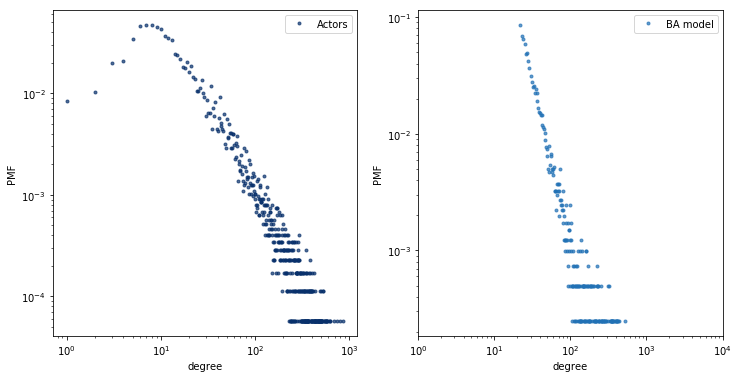

In [61]:
act_pmf = Pmf(degrees(actors))

thinkplot.preplot(cols=2)
thinkplot.Pdf(act_pmf, style='.', label='Actors')
thinkplot.config(xscale='log', yscale='log',
                 xlabel='degree', ylabel='PMF')

thinkplot.subplot(2)

thinkplot.Pdf(pmf_ba, style='.', label='BA model')
thinkplot.config(xlabel='degree', ylabel='PMF')
thinkplot.config(xlim=[1, 1e4],
                 xscale='log', yscale='log')

Just by looking at the graph, it seems to follow a power-law distribution fairly closely. It also has the deviations from a power-law distribution that many real-world networks seem to have: deviation in the body of the data, as well as noise at very high degrees.

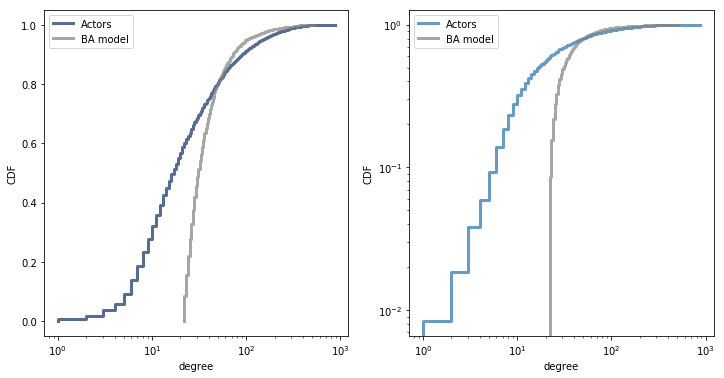

In [62]:
cdf_act = Cdf(degrees(actors), label='Actors')
thinkplot.preplot(cols=2)

thinkplot.Cdf(cdf_act)
thinkplot.Cdf(cdf_ba, color='gray')
thinkplot.config(xlabel='degree', xscale='log',
                 ylabel='CDF')

thinkplot.subplot(2)

thinkplot.Cdf(cdf_act)
thinkplot.Cdf(cdf_ba, color='gray')
thinkplot.config(xlabel='degree', xscale='log',
                 yscale='log', ylabel='CDF')


The tail of the data appears to follow a power-law distribution fairly well.

**Exercise:** NetworkX provides a function called `powerlaw_cluster_graph` that implements the "Holme and Kim algorithm for growing graphs with powerlaw degree distribution and approximate average clustering".  Read the documentation of this function and see if you can use it to generate a graph that has the same number of nodes as the Facebook network, the same average degree, and the same clustering coefficient.  How does the degree distribution in the model compare to the actual distribution?

In [70]:
# 4039, 88234, 43.691, 0.603
G = nx.powerlaw_cluster_graph(4039, 22, 1)
# The number of nodes and number of edges are very similar
print(len(G), len(G.edges()))
print(len(fb), len(fb.edges()))

4039 88361
4039 88234


In [71]:
# The average clustering is somewhat lower in this graph than in the data set
print(average_clustering(G), average_clustering(fb))

0.285 0.595


In [72]:
# The mean degrees are almost identical
print(np.mean(degrees(G)), np.mean(degrees(fb)))

43.7538994801 43.6910126269


In [73]:
# The mean path lengths are fairly similar 
print(estimate_path_length(G), estimate_path_length(fb))

2.686 3.631


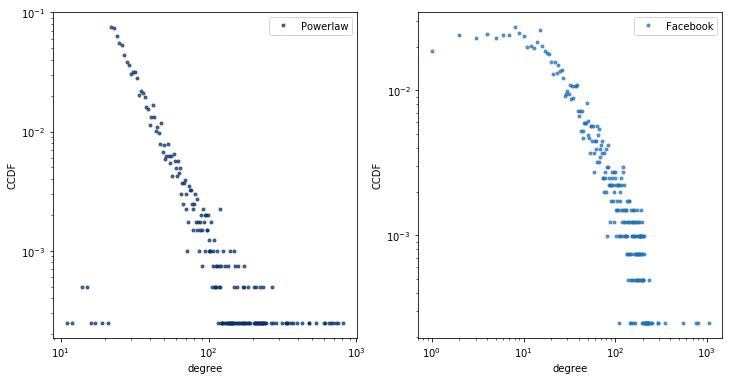

In [74]:
thinkplot.preplot(cols=2)

powerlaw_pmf = Pmf(degrees(G))
thinkplot.Pdf(powerlaw_pmf, style='.', label='Powerlaw')
thinkplot.config(xlabel='degree', xscale='log',
                 ylabel='CCDF', yscale='log')

thinkplot.subplot(2)

thinkplot.Pdf(pmf_fb, style='.', label='Facebook')
thinkplot.config(xlabel='degree', xscale='log',
                 ylabel='CCDF', yscale='log')

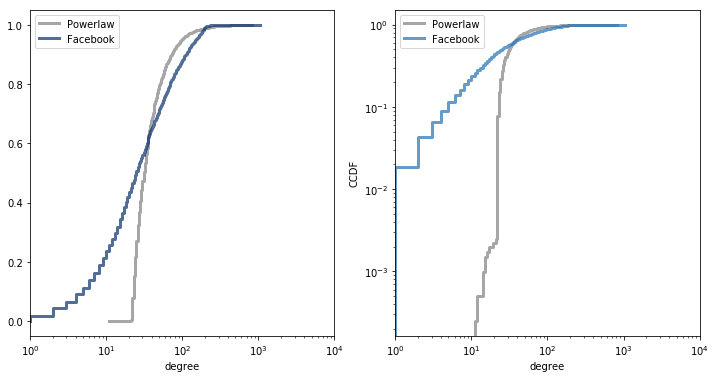

In [78]:
thinkplot.preplot(cols=2)

powerlaw_cdf = Cdf(degrees(G))
thinkplot.Cdf(powerlaw_cdf, label='Powerlaw', color='gray')
thinkplot.Cdf(cdf_fb, label='Facebook')
thinkplot.config(xlim = [0, 10e3], xlabel='degree', xscale='log')

thinkplot.subplot(2)
thinkplot.Cdf(powerlaw_cdf, label='Powerlaw', color='gray')
thinkplot.Cdf(cdf_fb, label='Facebook')
thinkplot.config(xlim = [0, 10e3], xlabel='degree', xscale='log',
                 ylabel='CCDF', yscale='log')

The distributions are fairly similar in their shape, but there is some amount of divergence at very low degrees. This is similar to the BA model; there is deviation in the body of the distribution, but the tails match fairly closely.